In [1]:
import collections

import numpy as np
import six
import tensorflow as tf

from deepchem.data import NumpyDataset
from deepchem.feat.graph_features import ConvMolFeaturizer
from deepchem.feat.mol_graphs import ConvMol
from deepchem.metrics import to_one_hot
from deepchem.models.tensorgraph.graph_layers import WeaveGather, DTNNEmbedding, DTNNStep, DTNNGather, DAGLayer, DAGGather, DTNNExtract, MessagePassing, SetGather
from deepchem.models.tensorgraph.graph_layers import WeaveLayerFactory
from deepchem.models.tensorgraph.layers import Dense, Concat, SoftMax, SoftMaxCrossEntropy, GraphConv, BatchNorm, GraphPool, GraphGather, WeightedError, Dropout, BatchNormalization, Stack, Flatten, GraphCNN, GraphCNNPool
from deepchem.models.tensorgraph.layers import L2Loss, Label, Weights, Feature
from deepchem.models.tensorgraph.tensor_graph import TensorGraph
from deepchem.trans import undo_transforms


class GraphConvTensorGraph(TensorGraph):

  def __init__(self, n_tasks, mode="classification",C1_filtnum=64,C2_filtnum=64,D_nodenum=32, **kwargs):
    """
    Parameters
    ----------
    n_tasks: int
      Number of tasks
    mode: str
      Either "classification" or "regression"
    Cn_filtnum: int
      Number of Conv filters in nth layer
    D_nodenum: int
      Number of nodes in dense layer
    
    """
    self.n_tasks = n_tasks
    self.mode = mode
    self.C1_filtnum = C1_filtnum
    self.C2_filtnum = C2_filtnum
    self.D_nodenum = D_nodenum
       
    self.error_bars = True if 'error_bars' in kwargs and kwargs['error_bars'] else False
    kwargs['use_queue'] = False
    super(GraphConvTensorGraph, self).__init__(**kwargs)
    self.build_graph()


  def build_graph(self):
    """
    Building graph structures:
    """
    self.atom_features = Feature(shape=(None, 75))
    self.degree_slice = Feature(shape=(None, 2), dtype=tf.int32)
    self.membership = Feature(shape=(None,), dtype=tf.int32)

    self.deg_adjs = []
    for i in range(0, 10 + 1):
      deg_adj = Feature(shape=(None, i + 1), dtype=tf.int32)
      self.deg_adjs.append(deg_adj)
    gc1 = GraphConv(
        self.C1_filtnum,
        activation_fn=tf.nn.relu,
        in_layers=[self.atom_features, self.degree_slice, self.membership] +
        self.deg_adjs)
    batch_norm1 = BatchNorm(in_layers=[gc1])
    gp1 = GraphPool(in_layers=[batch_norm1, self.degree_slice, self.membership]
                    + self.deg_adjs)
    gc2 = GraphConv(
        self.C2_filtnum,
        activation_fn=tf.nn.relu,
        in_layers=[gp1, self.degree_slice, self.membership] + self.deg_adjs)
    batch_norm2 = BatchNorm(in_layers=[gc2])
    gp2 = GraphPool(in_layers=[batch_norm2, self.degree_slice, self.membership]
                    + self.deg_adjs)
    dense = Dense(out_channels=self.D_nodenum, activation_fn=tf.nn.relu, in_layers=[gp2])
    batch_norm3 = BatchNorm(in_layers=[dense])
    readout = GraphGather(
        batch_size=self.batch_size,
        activation_fn=tf.nn.tanh,
        in_layers=[batch_norm3, self.degree_slice, self.membership] +
        self.deg_adjs)

    if self.error_bars == True:
      readout = Dropout(in_layers=[readout], dropout_prob=0.2)

    costs = []
    self.my_labels = []
    for task in range(self.n_tasks):
      if self.mode == 'classification':
        classification = Dense(
            out_channels=2, activation_fn=None, in_layers=[readout])

        softmax = SoftMax(in_layers=[classification])
        self.add_output(softmax)

        label = Label(shape=(None, 2))
        self.my_labels.append(label)
        cost = SoftMaxCrossEntropy(in_layers=[label, classification])
        costs.append(cost)
      if self.mode == 'regression':
        regression = Dense(
            out_channels=1, activation_fn=None, in_layers=[readout])
        self.add_output(regression)

        label = Label(shape=(None, 1))
        self.my_labels.append(label)
        cost = L2Loss(in_layers=[label, regression])
        costs.append(cost)
    if self.mode == "classification":
      entropy = Concat(in_layers=costs, axis=-1)
    elif self.mode == "regression":
      entropy = Stack(in_layers=costs, axis=1)
    self.my_task_weights = Weights(shape=(None, self.n_tasks))
    loss = WeightedError(in_layers=[entropy, self.my_task_weights])
    self.set_loss(loss)



  def default_generator(self,
                        traindataset,
                        validdataset,
                        metrics,
                        transformers=[],
                        epochs=1,
                        predict=False,
                        deterministic=True,
                        pad_batches=True):
    """
    
    modified to add validation step after one epoch training
    
    """
    
    
    global train_metric
    global valid_metric
    train_metric=[]
    valid_metric=[]

    for epoch in range(epochs):
      if not predict:
        print('Starting epoch %i' % epoch)
      for ind, (X_b, y_b, w_b, ids_b) in enumerate(
          traindataset.iterbatches(
              self.batch_size,
              pad_batches=pad_batches,
              deterministic=deterministic)):
        d = {}
        for index, label in enumerate(self.my_labels):
          if self.mode == 'classification':
            d[label] = to_one_hot(y_b[:, index])
          if self.mode == 'regression':
            d[label] = np.expand_dims(y_b[:, index], -1)
        d[self.my_task_weights] = w_b
        multiConvMol = ConvMol.agglomerate_mols(X_b)
        d[self.atom_features] = multiConvMol.get_atom_features()
        d[self.degree_slice] = multiConvMol.deg_slice
        d[self.membership] = multiConvMol.membership
        for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
          d[self.deg_adjs[i - 1]] = multiConvMol.get_deg_adjacency_lists()[i]
        yield d
      if not predict:
        print('Starting validation epoch %i' % epoch)
        
        if 'mean-mean_absolute_error' in self.evaluate(dataset=traindataset, metrics=metrics, transformers=transformers, per_task_metrics=False):
            train_metric.append(self.evaluate(dataset=traindataset, metrics=metrics, transformers=transformers, per_task_metrics=False)['mean-mean_absolute_error'])
            valid_metric.append(self.evaluate(dataset=validdataset, metrics=metrics, transformers=transformers, per_task_metrics=False)['mean-mean_absolute_error'])

        
  def default_generator_2(self,
#                        traindataset,
                        validdataset,
#                        metrics,
#                        transformers=[],
                        epochs=1,
                        predict=False,
                        deterministic=True,
                        pad_batches=True):
    """
    the same as unmodified default_generator
    used for prediction
    """
    
    
    for epoch in range(epochs):
      if not predict:
        print('Starting epoch %i' % epoch)
      for ind, (X_b, y_b, w_b, ids_b) in enumerate(
          validdataset.iterbatches(
              self.batch_size,
              pad_batches=pad_batches,
              deterministic=deterministic)):
        d = {}
        for index, label in enumerate(self.my_labels):
          if self.mode == 'classification':
            d[label] = to_one_hot(y_b[:, index])
          if self.mode == 'regression':
            d[label] = np.expand_dims(y_b[:, index], -1)
        d[self.my_task_weights] = w_b
        multiConvMol = ConvMol.agglomerate_mols(X_b)
        d[self.atom_features] = multiConvMol.get_atom_features()
        d[self.degree_slice] = multiConvMol.deg_slice
        d[self.membership] = multiConvMol.membership
        for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
          d[self.deg_adjs[i - 1]] = multiConvMol.get_deg_adjacency_lists()[i]
        yield d

  def fit2(self,
          traindataset,
          validdataset,
          metrics,
          transformers=[],
          nb_epoch=10,
          max_checkpoints_to_keep=5,
          checkpoint_interval=1000,
          deterministic=False,
          restore=False,
          submodel=None,
          **kwargs):
    """Train this model on a dataset using modifed default_generator.
    validation step using metrics is performed after one epoch training. 
    

    Parameters
    ----------
    dataset: Dataset
      the Dataset to train on
    nb_epoch: int
      the number of epochs to train for
    max_checkpoints_to_keep: int
      the maximum number of checkpoints to keep.  Older checkpoints are discarded.
    checkpoint_interval: int
      the frequency at which to write checkpoints, measured in training steps.
      Set this to 0 to disable automatic checkpointing.
    deterministic: bool
      if True, the samples are processed in order.  If False, a different random
      order is used for each epoch.
    restore: bool
      if True, restore the model from the most recent checkpoint and continue training
      from there.  If False, retrain the model from scratch.
    submodel: Submodel
      an alternate training objective to use.  This should have been created by
      calling create_submodel().
    """
    return self.fit_generator(
        self.default_generator(
            traindataset,validdataset,metrics,transformers, epochs=nb_epoch, deterministic=deterministic, **kwargs),
        max_checkpoints_to_keep, checkpoint_interval, restore, submodel)


  def predict_on_generator(self, generator, transformers=[], outputs=None):
    if not self.built:
      self.build()
    if outputs is None:
      outputs = self.outputs
    elif not isinstance(outputs, collections.Sequence):
      outputs = [outputs]
    with self._get_tf("Graph").as_default():
      # Gather results for each output
      results = [[] for out in outputs]
      for feed_dict in generator:
        feed_dict = {
            self.layers[k.name].out_tensor: v
            for k, v in six.iteritems(feed_dict)
        }
        # Recording the number of samples in the input batch
        n_samples = max(feed_dict[self.membership.out_tensor]) + 1
        feed_dict[self._training_placeholder] = 0.0
        feed_results = self.session.run(outputs, feed_dict=feed_dict)
        if len(feed_results) > 1:
          if len(transformers):
            raise ValueError("Does not support transformations "
                             "for multiple outputs.")
        elif len(feed_results) == 1:
          result = undo_transforms(feed_results[0], transformers)
          feed_results = [result]
        for ind, result in enumerate(feed_results):
          # GraphConvTensorGraph constantly outputs batch_size number of
          # results, only valid samples should be appended to final results
          results[ind].append(result[:n_samples])

      final_results = []
      for result_list in results:
        final_results.append(np.concatenate(result_list, axis=0))
      # If only one output, just return array
      if len(final_results) == 1:
        return final_results[0]
      else:
        return final_results



  def predict_proba_on_generator(self, generator, transformers=[],
                                 outputs=None):
    if not self.built:
      self.build()
    with self._get_tf("Graph").as_default():
      out_tensors = [x.out_tensor for x in self.outputs]
      results = []
      for feed_dict in generator:
        feed_dict = {
            self.layers[k.name].out_tensor: v
            for k, v in six.iteritems(feed_dict)
        }
        n_samples = max(feed_dict[self.membership.out_tensor]) + 1
        feed_dict[self._training_placeholder] = 1.0  ##
        result = np.array(self.session.run(out_tensors, feed_dict=feed_dict))
        if len(result.shape) == 3:
          result = np.transpose(result, axes=[1, 0, 2])
        if len(transformers) > 0:
          result = undo_transforms(result, transformers)
        results.append(result[:n_samples])
      return np.concatenate(results, axis=0)



  def evaluate(self, dataset, metrics, transformers=[], per_task_metrics=False):
    if not self.built:
      self.build()
    return self.evaluate_generator(
        self.default_generator_2(dataset, predict=True),
        metrics,
        labels=self.my_labels,
        weights=[self.my_task_weights],
        per_task_metrics=per_task_metrics)



  def bayesian_predict(self,
                       dataset,
                       transformers=[],
                       n_passes=4,
                       untransform=False):
    """Generates predictions and confidences on a dataset object
     https://arxiv.org/pdf/1506.02142.pdf

    # Returns:
      mu: numpy ndarray of shape (n_samples, n_tasks)
      sigma: numpy ndarray of shape (n_samples, n_tasks)
    """
    X = dataset.X
    max_index = X.shape[0] - 1
    num_batches = (max_index // self.batch_size) + 1

    mus = []
    sigmas = []
    for i in range(num_batches):
      start = i * self.batch_size
      end = min((i + 1) * self.batch_size, max_index + 1)
      batch = X[start:end]
      mu, sigma = self.bayesian_predict_on_batch(
          batch, transformers=[], n_passes=n_passes)
      mus.append(mu)
      sigmas.append(sigma)
    mu = np.concatenate(mus, axis=0)
    sigma = np.concatenate(sigmas, axis=0) + 0.55

    if untransform:
      mu = undo_transforms(mu, transformers)
      for i in range(sigma.shape[1]):
        sigma[:, i] = sigma[:, i] * transformers[0].y_stds[i]

    return mu[:max_index + 1], sigma[:max_index + 1]



  def bayesian_predict_on_batch(self, X, transformers=[], n_passes=4):
    """
    Returns:
      mu: numpy ndarray of shape (n_samples, n_tasks)
      sigma: numpy ndarray of shape (n_samples, n_tasks)
    """
    dataset = NumpyDataset(X=X, y=None, n_tasks=len(self.outputs))
    y_ = []
    for i in range(n_passes):
      generator = self.default_generator_2(
          dataset, predict=True, pad_batches=True)
      y_.append(self.predict_on_generator(generator, transformers))

    # Concatenates along 0-th dimension
    y_ = np.array(y_)
    mu = np.mean(y_, axis=0)
    sigma = np.std(y_, axis=0)

    return mu, sigma



  def predict_on_smiles(self, smiles, transformers=[], untransform=False):
    """Generates predictions on a numpy array of smile strings

    # Returns:
      y_: numpy ndarray of shape (n_samples, n_tasks)
    """
    max_index = len(smiles) - 1
    n_tasks = len(self.outputs)
    num_batches = (max_index // self.batch_size) + 1
    featurizer = ConvMolFeaturizer()

    y_ = []
    for i in range(num_batches):
      start = i * self.batch_size
      end = min((i + 1) * self.batch_size, max_index + 1)
      smiles_batch = smiles[start:end]
      y_.append(
          self.predict_on_smiles_batch(smiles_batch, featurizer, transformers))
    y_ = np.concatenate(y_, axis=0)[:max_index + 1]
    y_ = y_.reshape(-1, n_tasks)

    if untransform:
      y_ = undo_transforms(y_, transformers)

    return y_

  def predict(self, dataset, transformers=[], outputs=None):
    """
    Uses self to make predictions on provided Dataset object.

    Parameters
    ----------
    dataset: dc.data.Dataset
      Dataset to make prediction on
    transformers: list
      List of dc.trans.Transformers.
    outputs: object
      If outputs is None, then will assume outputs = self.outputs[0] (single
      output). If outputs is a Layer/Tensor, then will evaluate and return as a
      single ndarray. If outputs is a list of Layers/Tensors, will return a list
      of ndarrays.

    Returns
    -------
    results: numpy ndarray or list of numpy ndarrays
    """
    generator = self.default_generator_2(dataset, predict=True, pad_batches=False)
    return self.predict_on_generator(generator, transformers, outputs)
    

In [2]:


from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os

import numpy as np
import tensorflow as tf
import deepchem as dc

from deepchem.utils.save import load_from_disk
from deepchem.feat.graph_features import ConvMolFeaturizer, WeaveFeaturizer

input_data='../ChEMBL/hDAT_pIC50.csv'

tasks = ['affinity']
#featurizer=WeaveFeaturizer()
featurizer=ConvMolFeaturizer()


loader = dc.data.CSVLoader(tasks=tasks, smiles_field="canonical_smiles",featurizer=featurizer)
dataset=loader.featurize(input_data)


Loading raw samples now.
shard_size: 8192
About to start loading CSV from ../ChEMBL/hDAT_pIC50.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 2.792 s
TIMING: dataset construction took 3.245 s
Loading dataset from disk.


In [3]:
import deepchem as dc
import tempfile, shutil
from deepchem.splits.splitters import RandomSplitter

splitter=RandomSplitter()
train_data,valid_data,test_data=splitter.train_valid_test_split(dataset)



TIMING: dataset construction took 0.466 s
Loading dataset from disk.
TIMING: dataset construction took 0.235 s
Loading dataset from disk.
TIMING: dataset construction took 0.235 s
Loading dataset from disk.


In [4]:
out_path = '../ChEMBL/hDAT/logdir/'

C1_filtnum = 128
C2_filtnum = 256
D_nodenum = 32

graph_structure = 'GC{0}_GP_GC{1}_GP_D{2}'.format(C1_filtnum,C2_filtnum,D_nodenum)

model_dir = out_path+graph_structure+'/'

np.random.seed(0)
random_seed = 0

model = GraphConvTensorGraph(len(tasks), dropout=0.5, batch_size=50, mode='regression', 
                             C1_filtnum = C1_filtnum, C2_filtnum = C2_filtnum, D_nodenum = D_nodenum,
                             random_seed=random_seed)
#model = WeaveTensorGraph(len(tasks), dropout=0.5, batch_size=100, mode='regression')

from sklearn.metrics import mean_absolute_error
from deepchem.metrics import rms_score
import deepchem.hyper.grid_search

metric = dc.metrics.Metric(
    mean_absolute_error, task_averager=np.mean, mode="regression")
   

In [5]:
model.build()
model.save()
model.fit2(train_data,valid_data, metrics=[metric], nb_epoch=500, deterministic=True)

print(train_metric)
print(valid_metric)

/home/nagayasu/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Starting epoch 0
Starting validation epoch 0
computed_metrics: [2.7065375478833955]
computed_metrics: [2.7065375478833955]
computed_metrics: [2.7269322666543947]
Starting epoch 1
Starting validation epoch 1
computed_metrics: [1.8654848823165924]
computed_metrics: [1.8654848823165924]
computed_metrics: [1.9029787119585708]
Starting epoch 2
Starting validation epoch 2
computed_metrics: [1.2694316000448473]
computed_metrics: [1.2694316000448473]
computed_metrics: [1.3267930809182147]
Starting epoch 3
Starting validation epoch 3
computed_metrics: [1.0442957719583819]
computed_metrics: [1.0442957719583819]
computed_metrics: [1.0866286915532648]
Starting epoch 4
Starting validation epoch 4
computed_metrics: [0.9651598626120231]
computed_metrics: [0.9651598626120231]
computed_metrics: [0.9873387978429967]
Starting epoch 5
Starting validation epoch 5
computed_metrics: [0.9423955391020045]
computed_metrics: [0.9423955391020045]
computed_metrics: [0.9587906770266825]
Starting epoch 6
Starting va

computed_metrics: [0.564250135809285]
computed_metrics: [0.564250135809285]
computed_metrics: [0.5892027509027323]
Starting epoch 51
Starting validation epoch 51
computed_metrics: [0.5516862257297159]
computed_metrics: [0.5516862257297159]
computed_metrics: [0.5736519818692168]
Starting epoch 52
Starting validation epoch 52
computed_metrics: [0.5387769380017555]
computed_metrics: [0.5387769380017555]
computed_metrics: [0.566500740654387]
Starting epoch 53
Starting validation epoch 53
computed_metrics: [0.5543862042754326]
computed_metrics: [0.5543862042754326]
computed_metrics: [0.5769447403776805]
Starting epoch 54
Starting validation epoch 54
computed_metrics: [0.5635527559664726]
computed_metrics: [0.5635527559664726]
computed_metrics: [0.5897531766803413]
Starting epoch 55
Starting validation epoch 55
computed_metrics: [0.5247522999216538]
computed_metrics: [0.5247522999216538]
computed_metrics: [0.5581962123374375]
Starting epoch 56
Starting validation epoch 56
computed_metrics: [

computed_metrics: [0.5066137318324568]
computed_metrics: [0.5066137318324568]
computed_metrics: [0.6001252053535575]
Starting epoch 101
Starting validation epoch 101
computed_metrics: [0.5847019550166684]
computed_metrics: [0.5847019550166684]
computed_metrics: [0.6795266920017675]
Starting epoch 102
Starting validation epoch 102
computed_metrics: [0.5433948000969017]
computed_metrics: [0.5433948000969017]
computed_metrics: [0.6293700749407691]
Starting epoch 103
Starting validation epoch 103
computed_metrics: [0.5059637844327962]
computed_metrics: [0.5059637844327962]
computed_metrics: [0.5961481283935751]
Starting epoch 104
Starting validation epoch 104
computed_metrics: [0.44890068612845346]
computed_metrics: [0.44890068612845346]
computed_metrics: [0.5503588668703038]
Starting epoch 105
Starting validation epoch 105
computed_metrics: [0.4036802833572435]
computed_metrics: [0.4036802833572435]
computed_metrics: [0.5263432965991205]
Starting epoch 106
Starting validation epoch 106
co

computed_metrics: [0.35181661307525575]
computed_metrics: [0.5012178415715447]
Starting epoch 150
Starting validation epoch 150
computed_metrics: [0.33827390284673603]
computed_metrics: [0.33827390284673603]
computed_metrics: [0.5294377094749113]
Starting epoch 151
Starting validation epoch 151
computed_metrics: [0.3712506509718007]
computed_metrics: [0.3712506509718007]
computed_metrics: [0.5437925126559422]
Starting epoch 152
Starting validation epoch 152
computed_metrics: [0.3820660534785305]
computed_metrics: [0.3820660534785305]
computed_metrics: [0.5479240632503657]
Starting epoch 153
Starting validation epoch 153
computed_metrics: [0.4157906831279813]
computed_metrics: [0.4157906831279813]
computed_metrics: [0.601778734543009]
Starting epoch 154
Starting validation epoch 154
computed_metrics: [0.4032024420924998]
computed_metrics: [0.4032024420924998]
computed_metrics: [0.5863549063386532]
Starting epoch 155
Starting validation epoch 155
computed_metrics: [0.32741331642522076]
c

Starting validation epoch 199
computed_metrics: [0.33923247264789547]
computed_metrics: [0.33923247264789547]
computed_metrics: [0.585424108189024]
Starting epoch 200
Starting validation epoch 200
computed_metrics: [0.25962583107529175]
computed_metrics: [0.25962583107529175]
computed_metrics: [0.530172250573714]
Starting epoch 201
Starting validation epoch 201
computed_metrics: [0.2991432667893524]
computed_metrics: [0.2991432667893524]
computed_metrics: [0.5741331436163073]
Starting epoch 202
Starting validation epoch 202
computed_metrics: [0.35599766623236306]
computed_metrics: [0.35599766623236306]
computed_metrics: [0.5860172415595303]
Starting epoch 203
Starting validation epoch 203
computed_metrics: [0.269329544055813]
computed_metrics: [0.269329544055813]
computed_metrics: [0.49986662223811285]
Starting epoch 204
Starting validation epoch 204
computed_metrics: [0.2787287293086693]
computed_metrics: [0.2787287293086693]
computed_metrics: [0.5360608220654441]
Starting epoch 205
S

computed_metrics: [0.3051085179508174]
computed_metrics: [0.5353087566313758]
Starting epoch 249
Starting validation epoch 249
computed_metrics: [0.2615888739741701]
computed_metrics: [0.2615888739741701]
computed_metrics: [0.5364574526813791]
Starting epoch 250
Starting validation epoch 250
computed_metrics: [0.31620068574944676]
computed_metrics: [0.31620068574944676]
computed_metrics: [0.5798089570119991]
Starting epoch 251
Starting validation epoch 251
computed_metrics: [0.297027948572497]
computed_metrics: [0.297027948572497]
computed_metrics: [0.5768402701435673]
Starting epoch 252
Starting validation epoch 252
computed_metrics: [0.24798322440993878]
computed_metrics: [0.24798322440993878]
computed_metrics: [0.5344016985941653]
Starting epoch 253
Starting validation epoch 253
computed_metrics: [0.3080388284173519]
computed_metrics: [0.3080388284173519]
computed_metrics: [0.5779275263301525]
Starting epoch 254
Starting validation epoch 254
computed_metrics: [0.26811484177786976]
c

Starting validation epoch 298
computed_metrics: [0.2629030073396963]
computed_metrics: [0.2629030073396963]
computed_metrics: [0.5721321778416409]
Starting epoch 299
Starting validation epoch 299
computed_metrics: [0.2012944358212198]
computed_metrics: [0.2012944358212198]
computed_metrics: [0.5339889621352699]
Starting epoch 300
Starting validation epoch 300
computed_metrics: [0.25201634841850906]
computed_metrics: [0.25201634841850906]
computed_metrics: [0.5727165189115211]
Starting epoch 301
Starting validation epoch 301
computed_metrics: [0.25789358957460373]
computed_metrics: [0.25789358957460373]
computed_metrics: [0.5613975250736677]
Starting epoch 302
Starting validation epoch 302
computed_metrics: [0.21607218895627728]
computed_metrics: [0.21607218895627728]
computed_metrics: [0.5317853902078993]
Starting epoch 303
Starting validation epoch 303
computed_metrics: [0.2922632846938916]
computed_metrics: [0.2922632846938916]
computed_metrics: [0.5945387946597998]
Starting epoch 30

computed_metrics: [0.2276677613664151]
computed_metrics: [0.2276677613664151]
computed_metrics: [0.5336194665284958]
Starting epoch 348
Starting validation epoch 348
computed_metrics: [0.24138272414630668]
computed_metrics: [0.24138272414630668]
computed_metrics: [0.5741564318173313]
Starting epoch 349
Starting validation epoch 349
computed_metrics: [0.24358224964556227]
computed_metrics: [0.24358224964556227]
computed_metrics: [0.5754481028702664]
Starting epoch 350
Starting validation epoch 350
computed_metrics: [0.19918216918231227]
computed_metrics: [0.19918216918231227]
computed_metrics: [0.5399836499916707]
Starting epoch 351
Starting validation epoch 351
computed_metrics: [0.1994449906065197]
computed_metrics: [0.1994449906065197]
computed_metrics: [0.5392150561031945]
Starting epoch 352
Starting validation epoch 352
computed_metrics: [0.18056477838518273]
computed_metrics: [0.18056477838518273]
computed_metrics: [0.5213376814148711]
Starting epoch 353
Starting validation epoch 

computed_metrics: [0.3215355110280496]
computed_metrics: [0.6091222513546893]
Starting epoch 397
Starting validation epoch 397
computed_metrics: [0.22209330343726824]
computed_metrics: [0.22209330343726824]
computed_metrics: [0.5731264837770966]
Starting epoch 398
Starting validation epoch 398
computed_metrics: [0.2840459698717824]
computed_metrics: [0.2840459698717824]
computed_metrics: [0.6108425700572769]
Starting epoch 399
Starting validation epoch 399
computed_metrics: [0.27499253737619567]
computed_metrics: [0.27499253737619567]
computed_metrics: [0.553740058002703]
Starting epoch 400
Starting validation epoch 400
computed_metrics: [0.22074599745040277]
computed_metrics: [0.22074599745040277]
computed_metrics: [0.5645662215960564]
Starting epoch 401
Starting validation epoch 401
computed_metrics: [0.28977654383892665]
computed_metrics: [0.28977654383892665]
computed_metrics: [0.5925404640939008]
Starting epoch 402
Starting validation epoch 402
computed_metrics: [0.196050425410043

computed_metrics: [0.24994410521395943]
computed_metrics: [0.5895317091850618]
Starting epoch 446
Starting validation epoch 446
computed_metrics: [0.22621586638363475]
computed_metrics: [0.22621586638363475]
computed_metrics: [0.5640495877625402]
Starting epoch 447
Starting validation epoch 447
computed_metrics: [0.19801843154246807]
computed_metrics: [0.19801843154246807]
computed_metrics: [0.557489942479573]
Starting epoch 448
Starting validation epoch 448
computed_metrics: [0.25945546203127196]
computed_metrics: [0.25945546203127196]
computed_metrics: [0.6020630229814481]
Starting epoch 449
Starting validation epoch 449
computed_metrics: [0.1841635263351545]
computed_metrics: [0.1841635263351545]
computed_metrics: [0.5686449905738369]
Starting epoch 450
Starting validation epoch 450
computed_metrics: [0.2117324537245168]
computed_metrics: [0.2117324537245168]
computed_metrics: [0.5788271082229836]
Starting epoch 451
Starting validation epoch 451
computed_metrics: [0.2224433571915164

computed_metrics: [0.22927151655440223]
computed_metrics: [0.5763280703224634]
Starting epoch 495
Starting validation epoch 495
computed_metrics: [0.20737428061391525]
computed_metrics: [0.20737428061391525]
computed_metrics: [0.5531031430463085]
Starting epoch 496
Starting validation epoch 496
computed_metrics: [0.22958891281532146]
computed_metrics: [0.22958891281532146]
computed_metrics: [0.5767973892988676]
Starting epoch 497
Starting validation epoch 497
computed_metrics: [0.22075245730201212]
computed_metrics: [0.22075245730201212]
computed_metrics: [0.5641973985536732]
Starting epoch 498
Starting validation epoch 498
computed_metrics: [0.18663877648344956]
computed_metrics: [0.18663877648344956]
computed_metrics: [0.5552001228631714]
Starting epoch 499
Starting validation epoch 499
computed_metrics: [0.2281442801191925]
computed_metrics: [0.2281442801191925]
computed_metrics: [0.5473492561202162]
[2.7065375478833955, 1.8654848823165924, 1.2694316000448473, 1.0442957719583819, 0.

In [6]:
import numpy as np

train_score = np.array(train_metric)
valid_score = np.array(valid_metric)

best_epoch = valid_score.argmin()
best_valid_score = valid_score.min()

score_summary = np.vstack((valid_score,train_score))

print(best_epoch)
print(best_valid_score)
print(train_score)
print(valid_score)
print(score_summary)
print(np.rot90(score_summary,-1))



out_filename = out_path+graph_structure + '_500epochs_summary.csv'

np.savetxt(out_filename, np.rot90(score_summary,-1), delimiter=',')


136
0.4953603820632196
[2.70653755 1.86548488 1.2694316  1.04429577 0.96515986 0.94239554
 0.92848589 0.91430568 0.91100914 0.89852787 0.86018418 0.87321561
 0.85982234 0.8547932  0.84874233 0.84015725 0.83647353 0.82653575
 0.82287073 0.81405796 0.80700714 0.80637519 0.79622101 0.79414635
 0.78353304 0.7812602  0.79584815 0.80782998 0.79106777 0.7653686
 0.77382068 0.75344437 0.73886271 0.73298612 0.73913976 0.7176045
 0.71538639 0.70353872 0.70945151 0.69010528 0.68402361 0.67215349
 0.64635724 0.64768798 0.64667123 0.62723297 0.59380668 0.57222299
 0.57574535 0.56359265 0.56425014 0.55168623 0.53877694 0.5543862
 0.56355276 0.5247523  0.60134257 0.54533961 0.53828645 0.52073081
 0.51330101 0.52607118 0.50618724 0.49691756 0.49993382 0.52017646
 0.48218321 0.494486   0.51121977 0.48071423 0.48690056 0.49426857
 0.49049656 0.50315295 0.51528735 0.5572107  0.60093007 0.49667949
 0.47437244 0.53938604 0.49623334 0.50176731 0.52851876 0.49764396
 0.50443122 0.52764928 0.52020184 0.509600

In [7]:
model2 = GraphConvTensorGraph(len(tasks), dropout=0.5, batch_size=50, mode='regression',
                              C1_filtnum = C1_filtnum, C2_filtnum = C2_filtnum, D_nodenum = D_nodenum,
                              random_seed=random_seed, tensorboard=True, tensorboard_log_frequency=1, model_dir=model_dir)



In [8]:
model2.fit2(train_data,valid_data, metrics=[metric], nb_epoch=best_epoch+1, restore=False, deterministic=True)

/home/nagayasu/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Starting epoch 0
Starting validation epoch 0
computed_metrics: [2.4804938539721433]
computed_metrics: [2.4804938539721433]
computed_metrics: [2.513657510260531]
Starting epoch 1
Starting validation epoch 1
computed_metrics: [1.664566445573324]
computed_metrics: [1.664566445573324]
computed_metrics: [1.7147046493715548]
Starting epoch 2
Starting validation epoch 2
computed_metrics: [1.1862834311824362]
computed_metrics: [1.1862834311824362]
computed_metrics: [1.2649082950545403]
Starting epoch 3
Starting validation epoch 3
computed_metrics: [1.0093190277832296]
computed_metrics: [1.0093190277832296]
computed_metrics: [1.0541761952060316]
Starting epoch 4
Starting validation epoch 4
computed_metrics: [0.9566274972030095]
computed_metrics: [0.9566274972030095]
computed_metrics: [0.9727992283375085]
Starting epoch 5
Starting validation epoch 5
computed_metrics: [0.9635385989415285]
computed_metrics: [0.9635385989415285]
computed_metrics: [0.9843126365971037]
Starting epoch 6
Starting valid

computed_metrics: [0.5574501408432391]
computed_metrics: [0.5574501408432391]
computed_metrics: [0.613229333635951]
Starting epoch 51
Starting validation epoch 51
computed_metrics: [0.5955260136553583]
computed_metrics: [0.5955260136553583]
computed_metrics: [0.6573387674552905]
Starting epoch 52
Starting validation epoch 52
computed_metrics: [0.6017472734864245]
computed_metrics: [0.6017472734864245]
computed_metrics: [0.6580787558790815]
Starting epoch 53
Starting validation epoch 53
computed_metrics: [0.5537276067896382]
computed_metrics: [0.5537276067896382]
computed_metrics: [0.6139908434868014]
Starting epoch 54
Starting validation epoch 54
computed_metrics: [0.5391484878875095]
computed_metrics: [0.5391484878875095]
computed_metrics: [0.5866895299749686]
Starting epoch 55
Starting validation epoch 55
computed_metrics: [0.5255466785312968]
computed_metrics: [0.5255466785312968]
computed_metrics: [0.5765166325291085]
Starting epoch 56
Starting validation epoch 56
computed_metrics:

computed_metrics: [0.4163487624725602]
computed_metrics: [0.4163487624725602]
computed_metrics: [0.5323958171258694]
Starting epoch 101
Starting validation epoch 101
computed_metrics: [0.45781746818514457]
computed_metrics: [0.45781746818514457]
computed_metrics: [0.5549655634385514]
Starting epoch 102
Starting validation epoch 102
computed_metrics: [0.5304044289902795]
computed_metrics: [0.5304044289902795]
computed_metrics: [0.6368196053525254]
Starting epoch 103
Starting validation epoch 103
computed_metrics: [0.4891894686112026]
computed_metrics: [0.4891894686112026]
computed_metrics: [0.6075638933252349]
Starting epoch 104
Starting validation epoch 104
computed_metrics: [0.6009767422557374]
computed_metrics: [0.6009767422557374]
computed_metrics: [0.6918220733515869]
Starting epoch 105
Starting validation epoch 105
computed_metrics: [0.6002983092862816]
computed_metrics: [0.6002983092862816]
computed_metrics: [0.6950793321749512]
Starting epoch 106
Starting validation epoch 106
co

12.462122428710945

In [9]:
model2.evaluate(train_data, metrics=[metric])
model2.evaluate(valid_data, metrics=[metric])
model2.evaluate(test_data, metrics=[metric])

computed_metrics: [0.3213302750171779]
computed_metrics: [0.49597662224893363]
computed_metrics: [0.5884682998152002]


{'mean-mean_absolute_error': 0.5884682998152002}

(1412, 1)
(1412, 1)
(1412, 1)


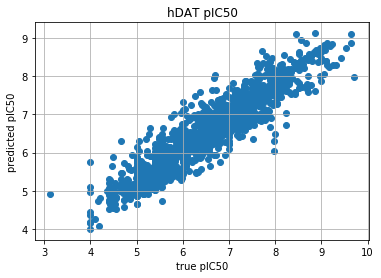

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt


a1 = np.reshape(train_data.ids, (-1,1))
a2 = np.reshape(model2.predict(train_data), (-1,1))
a3 = train_data.y

print(np.shape(a1))
print(np.shape(a2))
print(np.shape(a3))


a4 = np.concatenate((a1,a2,a3), axis=1)
#print(np.shape(a4))
#print(a4)

plt.scatter(a4[:,2], a4[:,1])
plt.title("hDAT pIC50")
plt.xlabel("true pIC50")
plt.ylabel("predicted pIC50")
plt.grid(True)
plt.show()

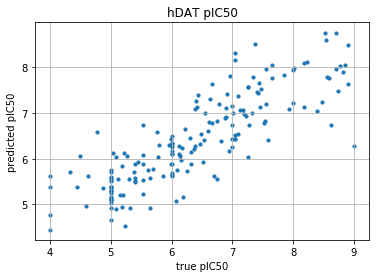

In [11]:
a11 = np.reshape(valid_data.ids, (-1,1))
a21 = np.reshape(model2.predict(valid_data), (-1,1))
a31 = valid_data.y

a41 = np.concatenate((a11,a21,a31), axis=1)
#print(np.shape(a41))
#print(a41)

plt.scatter(a41[:,2], a41[:,1],s=10)
plt.title("hDAT pIC50")
plt.xlabel("true pIC50")
plt.ylabel("predicted pIC50")
plt.grid(True)
plt.show()

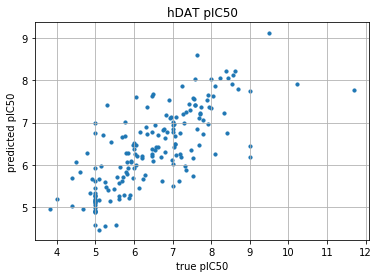

In [12]:
a12 = np.reshape(test_data.ids, (-1,1))
a22 = np.reshape(model2.predict(test_data), (-1,1))
a32 = test_data.y

a42 = np.concatenate((a12,a22,a32), axis=1)
#print(np.shape(a42))
#print(a42)

plt.scatter(a42[:,2], a42[:,1],s=10)
plt.title("hDAT pIC50")
plt.xlabel("true pIC50")
plt.ylabel("predicted pIC50")
plt.grid(True)
plt.show()

In [13]:
import scipy as sp
from scipy.stats import pearsonr, spearmanr

x = a4[:,1].astype(np.float32)
y = a4[:,2].astype(np.float32)

print(pearsonr(x,y))
print(spearmanr(x,y))

x = a41[:,1].astype(np.float32)
y = a41[:,2].astype(np.float32)

print(pearsonr(x,y))
print(spearmanr(x,y))

x = a42[:,1].astype(np.float32)
y = a42[:,2].astype(np.float32)

print(pearsonr(x,y))
print(spearmanr(x,y))

(0.9338563, 0.0)
SpearmanrResult(correlation=0.9331387486705389, pvalue=0.0)
(0.8393633, 3.3470175703754127e-48)
SpearmanrResult(correlation=0.8553492549838826, pvalue=7.278923790673157e-52)
(0.75654876, 4.149220008291093e-34)
SpearmanrResult(correlation=0.7688744181335859, pvalue=7.988284704841366e-36)
